In [1]:
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from Bio import Entrez
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
#create the colormap we want: white -> blue -> red

colors = [(1, 1, 1), (0.78, 0.84, 0.94), (0.92, 0.69, 0.65)]  # R -> G -> B
n_bins = 20  # Discretizes the interpolation into bins
cmap_name = 'white_blue_red'

# Create the colormap
cmap_wbr = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

In [3]:
#import microbemasst table after all the filters
microbemasst_filtered = pd.read_csv('/.../all_heads_microbes_after_all_filters.tsv', sep='\t')

#lets get the taxonomy lineage of each ncbi taxonomy id in this dataframe
microbes_list = microbemasst_filtered['Taxa_NCBI'].unique().tolist()


In [ ]:
#retrieve the lineages using Entrez

# email address, required by NCBI Entrez
Entrez.email = "hmannochiorusso@health.ucsd.edu"

def fetch_lineage(tax_id):
    handle = Entrez.efetch(db="taxonomy", id=tax_id, retmode="xml")
    records = Entrez.read(handle)
    handle.close()
    return records[0]

def parse_lineage(record):
    lineage_dict = {}
    for lineage in record["LineageEx"]:
        rank = lineage["Rank"]
        scientific_name = lineage["ScientificName"]
        lineage_dict[rank] = scientific_name
    return lineage_dict

def retrieve_lineages(tax_ids):
    lineage_data = []
    for i, tax_id in enumerate(tax_ids, start=1):
        try:
            record = fetch_lineage(tax_id)
            lineage_dict = parse_lineage(record)
            lineage_dict["TaxID"] = tax_id
            # Add the taxonomic level of the entered taxonomy ID
            taxonomic_level = record["Rank"]
            taxonomic_name = record["ScientificName"]
            lineage_dict[taxonomic_level] = taxonomic_name
        except Exception as e:
            # Handle errors by logging and adding an error entry to the lineage_data
            print(f"Error retrieving record for TaxID {tax_id}: {e}")
            lineage_dict = {"TaxID": tax_id, "Error": str(e)}

        lineage_data.append(lineage_dict)
        
        # Print a message every 10 retrieves
        if i % 1 == 0:
            print(f"{i} records retrieved")

    return lineage_data

# List of NCBI taxonomy IDs
tax_ids = microbes_list

lineage_data = retrieve_lineages(tax_ids)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(lineage_data)

# Reorder columns (optional)
cols = ["Taxa_NCBI", "superkingdom", "kingdom", "clade", "phylum", "class", "order", "family", "genus", "species"]
df = df.reindex(columns=cols)

# export
df.to_csv("/.../lineages_microbemasst_results.tsv", sep='\t', index=False)


In [4]:
ncbi_lineage = pd.read_csv('/Users/helenarusso/Documents/Pesquisa/UCSD Post-doc/Acyl lipids/FastMASST_searches/fastMASST_combined_tables/Validation_massQL_and_fastMASST_07_final/Additional_filter_nonfiltered_spectra.nosync/Microbes/lineages_microbemasst_results.tsv', sep='\t')
ncbi_lineage = ncbi_lineage.fillna('N/A')

microbemasst_filtered_taxonomy = pd.merge(microbemasst_filtered, ncbi_lineage, on='Taxa_NCBI', how='left')
microbemasst_filtered_taxonomy['annotation'] = 'C' + microbemasst_filtered_taxonomy['group_annotation'].str.split('-C').str[-1]


In [5]:
len(microbemasst_filtered_taxonomy['Head'].unique())

34

# Heatmap - microbeMASST - Head (Figure 2a)

In [6]:
# Lets get a table with the number of occurrences of each headgroup per microbial class
level_chosen = 'class'
yaxis = 'Head'

# Group the dataframe by 'Head' and 'delta_mass_round' and count the occurrences
grouped_df = microbemasst_filtered_taxonomy.groupby([yaxis, level_chosen]).size().reset_index(name='count')

# Pivot the grouped dataframe to have 'Head' as columns, 'delta_mass_round' as rows, and 'count' as values
pivot_table = grouped_df.pivot(index=level_chosen, columns=yaxis, values='count').fillna(0)

# Reset the index
pivot_table.reset_index(inplace=True)

#adjust table
pivot_table_t = pivot_table.T
pivot_table_t = pivot_table_t.reset_index()
pivot_table_t.columns = pivot_table_t.iloc[0]
pivot_table_t = pivot_table_t[1:]

pivot_table_t.set_index(level_chosen, inplace=True)

# to plot counts, we need to convert from object to integer
pivot_table_t = pivot_table_t.astype(int)
pivot_table_t = pivot_table_t.reset_index()
columns_for_heatmap = pivot_table_t.columns[1:]

#to perform log transformation, we need to add 1 to all values first
pivot_table_t.iloc[:, 1:] = pivot_table_t.iloc[:, 1:] + 1

log_transformed_data = np.log10(pivot_table_t[columns_for_heatmap])
log_transformed_data_with_annotations = pd.concat([pivot_table_t[level_chosen], log_transformed_data], axis=1)


In [7]:
from ete3 import NCBITaxa, Tree, TreeStyle, TextFace, add_face_to_node

df = log_transformed_data_with_annotations.copy()

ncbi = NCBITaxa()
level_chosen = 'class'  # Adjust as needed
list_headers = df.columns.tolist()
df = pd.DataFrame()
df[level_chosen] = list_headers
df = df.drop(0)
df = df[df['class'] != 'N/A']

# Function to get taxonomy ID with manual check for Verrucomicrobiia
def get_taxonomy_id(name):
    if name == 'Verrucomicrobiia':
        return 203494
    result = ncbi.get_name_translator([name])
    return result.get(name, [None])[0]

df['Taxonomy_IDs'] = df[level_chosen].apply(get_taxonomy_id)

# Create a dictinoary of the df dataframe
taxid_to_name = dict(zip(df['Taxonomy_IDs'].astype(str), df[level_chosen]))

def get_rank_for_taxid(taxid, rank_for_annotation):
    lineage = ncbi.get_lineage(taxid)
    ranks = ncbi.get_rank(lineage)
    for id, rank in ranks.items():
        if rank == rank_for_annotation:
            return ncbi.get_taxid_translator([id])[id]
    return None

# Configure this to the desired higher taxonomic level
rank_for_annotation = 'phylum'

df[rank_for_annotation.capitalize()] = df['Taxonomy_IDs'].apply(lambda x: get_rank_for_taxid(x, rank_for_annotation))

taxonomic_rank_to_annotation = dict(zip(df[level_chosen], df[rank_for_annotation.capitalize()]))

ncbi = NCBITaxa()
tax_ids = df['Taxonomy_IDs'].tolist()
tree = ncbi.get_topology(tax_ids)
order = []

# Update the tree's leaf names and annotate with the specified taxonomic rank
for leaf in tree:
    if leaf.name in taxid_to_name:
        leaf.name = taxid_to_name[leaf.name]
        order.append(leaf.name)  #to get the list with the order that they appear in the taxonomic tree. 
                                 #we need this to put the figure in the taxonomic order according to NCBI.
        if leaf.name in taxonomic_rank_to_annotation:
            annotation_name = taxonomic_rank_to_annotation[leaf.name]
            leaf.add_features(taxonomic_annotation=annotation_name)

# Customize the tree visualization to show the desired taxonomic rank names
def my_layout(node):
    if node.is_leaf() and hasattr(node, 'taxonomic_annotation'):
        annotation_name = f"({node.taxonomic_annotation})"
        F = TextFace(annotation_name, tight_text=True)
        add_face_to_node(F, node, column=1, position="aligned")
    
ts = TreeStyle()
ts.layout_fn = my_layout

# export tree for visualization
# output_file_path = '/Users/helenarusso/Downloads/microbes_class_phylum.pdf'
# tree.render(output_file_path, tree_style=ts, w=1000)


In [8]:
#then we need to put the dataframe we want to plot in the same order as the NCBI taxonomy

#first we need to extract the 'class' column and drop it
col = log_transformed_data_with_annotations[level_chosen]
log_transformed_data_with_annotations = log_transformed_data_with_annotations.drop(level_chosen, axis=1)

#exclude 'class' column and reorder and put the class column back 
log_transformed_data_with_annotations = log_transformed_data_with_annotations.reindex(columns=order) #order specified in the precious cell
log_transformed_data_with_annotations[level_chosen] = col


In [10]:
#We want the heads in the X axis, so we need to transpose the dafatrame
transposed = log_transformed_data_with_annotations.copy()
last_column = transposed.pop(transposed.columns[-1])
transposed.insert(0, last_column.name, last_column)

transposed = transposed.T
transposed = transposed.reset_index()
transposed.columns = transposed.iloc[0]
transposed = transposed[1:]

columns_for_heatmap = transposed.columns[1:]
transposed[columns_for_heatmap] = transposed[columns_for_heatmap].astype(np.float64)

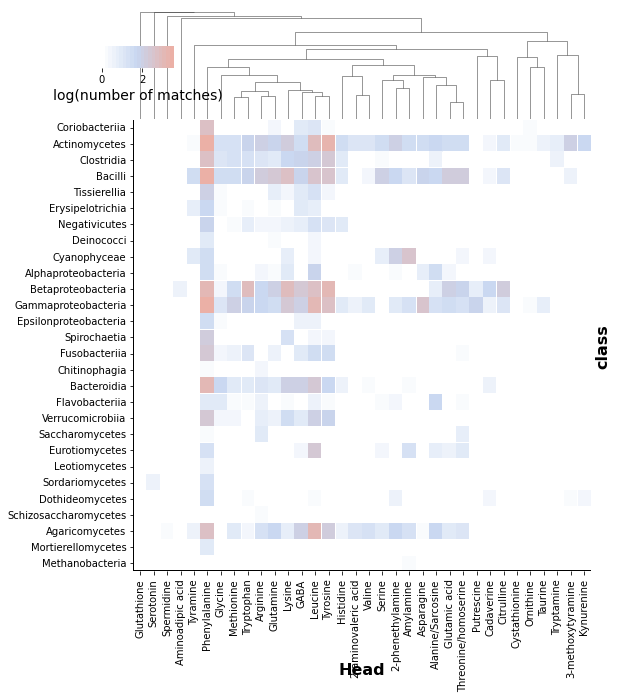

In [11]:
# Heatmap

fig = sns.clustermap(
    transposed[columns_for_heatmap], 
    cmap=cmap_wbr,
    metric='braycurtis', 
    col_cluster=True, 
    row_cluster=False,
    yticklabels=transposed[level_chosen],
    linewidths=0.001,
    linecolor = 'white',
    xticklabels=1,
    cbar_kws={'orientation': 'horizontal'}
)

cax = fig.ax_cbar
cax.set_position([.13, .90, .1, .03])  # Adjust the position and size of the color bar

cbar = fig.ax_heatmap.collections[0].colorbar
cbar.set_label('log(number of matches)', fontsize=14)  # Set the desired font size for the color bar label

fig.ax_heatmap.set_xlabel('Head', fontsize=16, weight='bold')
fig.ax_heatmap.set_ylabel(level_chosen, fontsize=16, weight='bold')
fig.ax_heatmap.xaxis.set_label_coords(0.5, -0.2) #coordinate X axis - more to the bottom

plt.gcf().set_size_inches(10, 10)

fig.ax_heatmap.yaxis.tick_left()

line_count = len(transposed[level_chosen].unique())
# Add an x-axis line at the bottom of the heatmap
fig.ax_heatmap.axhline(y=line_count, color='black', linewidth=2)
# Add a y-axis line on the left side of the heatmap
fig.ax_heatmap.axvline(x=0, color='black', linewidth=2)

fig.savefig('/.../Figure_2a.pdf')


# Heatmap - microbeMASST - Tail (Figure 2b)

In [18]:
# Lets get a table with the number of occurrences of each headgroup per microbial class
level_chosen = 'class'
yaxis = 'annotation'

# Group the dataframe by 'Head' and 'delta_mass_round' and count the occurrences
grouped_df = microbemasst_filtered_taxonomy.groupby([yaxis, level_chosen]).size().reset_index(name='count')

# Pivot the grouped dataframe to have 'Head' as columns, 'delta_mass_round' as rows, and 'count' as values
pivot_table = grouped_df.pivot(index=level_chosen, columns=yaxis, values='count').fillna(0)

# Reset the index
pivot_table.reset_index(inplace=True)

#adjust table
pivot_table_t = pivot_table.T
pivot_table_t = pivot_table_t.reset_index()
pivot_table_t.columns = pivot_table_t.iloc[0]
pivot_table_t = pivot_table_t[1:]

pivot_table_t.set_index(level_chosen, inplace=True)

# to plot counts, we need to convert from object to integer
pivot_table_t = pivot_table_t.astype(int)
pivot_table_t = pivot_table_t.reset_index()
columns_for_heatmap = pivot_table_t.columns[1:]

#to perform log transformation, we need to add 1 to all values first
pivot_table_t.iloc[:, 1:] = pivot_table_t.iloc[:, 1:] + 1

log_transformed_data = np.log10(pivot_table_t[columns_for_heatmap])
log_transformed_data_with_annotations = pd.concat([pivot_table_t[level_chosen], log_transformed_data], axis=1)

#put in the desired order of increasing chain lentgh
order = pd.read_csv('/.../deltas_annotation_reordered.txt', sep='\t')
order = order.rename(columns={'annotation': level_chosen})
log_transformed_data_with_annotations = pd.merge(log_transformed_data_with_annotations, 
                                                 order[[level_chosen, 'order']], on=level_chosen, how='left')
log_transformed_data_with_annotations = log_transformed_data_with_annotations.sort_values(by='order', ascending=True)
log_transformed_data_with_annotations = log_transformed_data_with_annotations.drop(['order', 'N/A'], axis=1)


In [19]:
from ete3 import NCBITaxa, Tree, TreeStyle, TextFace, add_face_to_node

df = log_transformed_data_with_annotations.copy()

ncbi = NCBITaxa()
level_chosen = 'class'  # Adjust as needed
list_headers = df.columns.tolist()
df = pd.DataFrame()
df[level_chosen] = list_headers
df = df.drop(0)
df = df[df['class'] != 'N/A']

# Function to get taxonomy ID with manual check for Verrucomicrobiia
def get_taxonomy_id(name):
    if name == 'Verrucomicrobiia':
        return 203494
    result = ncbi.get_name_translator([name])
    return result.get(name, [None])[0]

df['Taxonomy_IDs'] = df[level_chosen].apply(get_taxonomy_id)

# Create a dictinoary of the df dataframe
taxid_to_name = dict(zip(df['Taxonomy_IDs'].astype(str), df[level_chosen]))

def get_rank_for_taxid(taxid, rank_for_annotation):
    lineage = ncbi.get_lineage(taxid)
    ranks = ncbi.get_rank(lineage)
    for id, rank in ranks.items():
        if rank == rank_for_annotation:
            return ncbi.get_taxid_translator([id])[id]
    return None

# Configure this to the desired higher taxonomic level
rank_for_annotation = 'phylum'

df[rank_for_annotation.capitalize()] = df['Taxonomy_IDs'].apply(lambda x: get_rank_for_taxid(x, rank_for_annotation))

taxonomic_rank_to_annotation = dict(zip(df[level_chosen], df[rank_for_annotation.capitalize()]))

ncbi = NCBITaxa()
tax_ids = df['Taxonomy_IDs'].tolist()
tree = ncbi.get_topology(tax_ids)
order = []

# Update the tree's leaf names and annotate with the specified taxonomic rank
for leaf in tree:
    if leaf.name in taxid_to_name:
        leaf.name = taxid_to_name[leaf.name]
        order.append(leaf.name)  #to get the list with the order that they appear in the taxonomic tree. 
                                 #we need this to put the figure in the taxonomic order according to NCBI.
        if leaf.name in taxonomic_rank_to_annotation:
            annotation_name = taxonomic_rank_to_annotation[leaf.name]
            leaf.add_features(taxonomic_annotation=annotation_name)

# Customize the tree visualization to show the desired taxonomic rank names
def my_layout(node):
    if node.is_leaf() and hasattr(node, 'taxonomic_annotation'):
        annotation_name = f"({node.taxonomic_annotation})"
        F = TextFace(annotation_name, tight_text=True)
        add_face_to_node(F, node, column=1, position="aligned")
    
ts = TreeStyle()
ts.layout_fn = my_layout

# export tree for visualization
# output_file_path = '/Users/helenarusso/Downloads/microbes_class_phylum.pdf'
# tree.render(output_file_path, tree_style=ts, w=1000)


In [20]:
#then we need to put the dataframe we want to plot in the same order as the NCBI taxonomy

#first we need to extract the 'class' column and drop it
col = log_transformed_data_with_annotations[level_chosen]
log_transformed_data_with_annotations = log_transformed_data_with_annotations.drop(level_chosen, axis=1)

#exclude 'class' column and reorder and put the class column back 
log_transformed_data_with_annotations = log_transformed_data_with_annotations.reindex(columns=order) #order specified in the precious cell
log_transformed_data_with_annotations[level_chosen] = col


In [21]:
#We want the heads in the X axis, so we need to transpose the dafatrame
transposed = log_transformed_data_with_annotations.copy()
last_column = transposed.pop(transposed.columns[-1])
transposed.insert(0, last_column.name, last_column)

transposed = transposed.T
transposed = transposed.reset_index()
transposed.columns = transposed.iloc[0]
transposed = transposed[1:]

columns_for_heatmap = transposed.columns[1:]
transposed[columns_for_heatmap] = transposed[columns_for_heatmap].astype(np.float64)

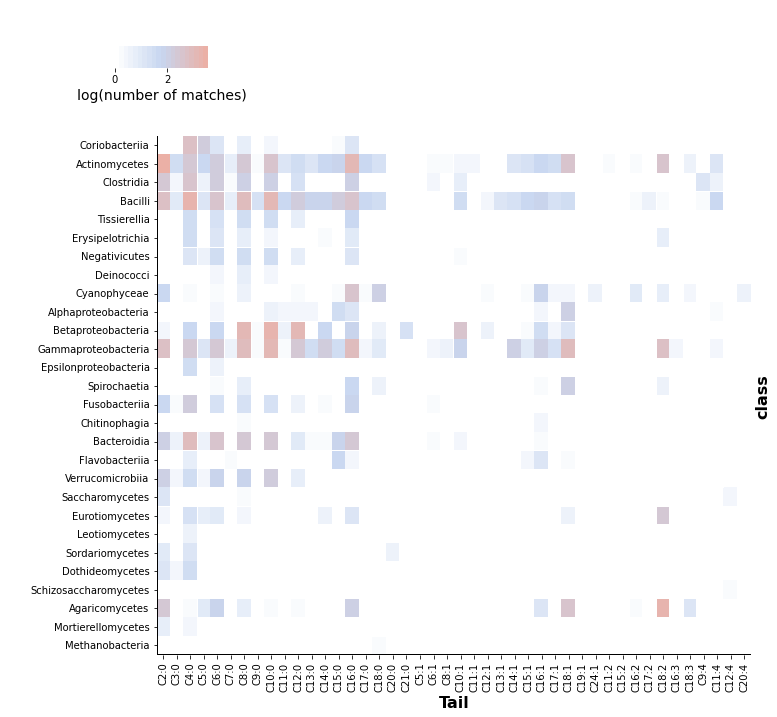

In [26]:
# Heatmap

fig = sns.clustermap(
    transposed[columns_for_heatmap], 
    cmap=cmap_wbr,
    metric='braycurtis', 
    col_cluster=False, 
    row_cluster=False,
    yticklabels=transposed[level_chosen],
    linewidths=0.001,
    linecolor = 'white',
    xticklabels=1,
    cbar_kws={'orientation': 'horizontal'}
)

cax = fig.ax_cbar
cax.set_position([.13, .90, .1, .03])  # Adjust the position and size of the color bar

cbar = fig.ax_heatmap.collections[0].colorbar
cbar.set_label('log(number of matches)', fontsize=14)  # Set the desired font size for the color bar label

fig.ax_heatmap.set_xlabel('Tail', fontsize=16, weight='bold')
fig.ax_heatmap.set_ylabel(level_chosen, fontsize=16, weight='bold')
fig.ax_heatmap.xaxis.set_label_coords(0.5, -0.2) #coordinate X axis - more to the bottom

plt.gcf().set_size_inches(13, 10)

fig.ax_heatmap.yaxis.tick_left()

line_count = len(transposed[level_chosen].unique())
# Add an x-axis line at the bottom of the heatmap
fig.ax_heatmap.axhline(y=line_count, color='black', linewidth=2)
# Add a y-axis line on the left side of the heatmap
fig.ax_heatmap.axvline(x=0, color='black', linewidth=2)

fig.savefig('/.../Figure_2b.pdf')


# Bar plots with microbeMASST counts (Figure 2b)

In [87]:
# Lets get a table with the number of occurrences of each headgroup per microbial class
level_chosen = 'class'
yaxis = 'Head'

# Group the dataframe by 'Head' and 'delta_mass_round' and count the occurrences
grouped_df = microbemasst_filtered_taxonomy.groupby([yaxis, level_chosen]).size().reset_index(name='count')

# Pivot the grouped dataframe to have 'Head' as columns, 'delta_mass_round' as rows, and 'count' as values
pivot_table = grouped_df.pivot(index=level_chosen, columns=yaxis, values='count').fillna(0)

# Reset the index
pivot_table.reset_index(inplace=True)

#adjust table
pivot_table_t = pivot_table.T
pivot_table_t = pivot_table_t.reset_index()
pivot_table_t.columns = pivot_table_t.iloc[0]
pivot_table_t = pivot_table_t[1:]

pivot_table_t.set_index(level_chosen, inplace=True)

# convert from object to integer
pivot_table_t = pivot_table_t.astype(int)
pivot_table_t = pivot_table_t.reset_index()


In [89]:
from ete3 import NCBITaxa, Tree, TreeStyle, TextFace, add_face_to_node

df = log_transformed_data_with_annotations.copy()

ncbi = NCBITaxa()
level_chosen = 'class'  # Adjust as needed
list_headers = df.columns.tolist()
df = pd.DataFrame()
df[level_chosen] = list_headers
df = df.drop(0)
df = df[df['class'] != 'N/A']

# Function to get taxonomy ID with manual check for Verrucomicrobiia
def get_taxonomy_id(name):
    if name == 'Verrucomicrobiia':
        return 203494
    result = ncbi.get_name_translator([name])
    return result.get(name, [None])[0]

df['Taxonomy_IDs'] = df[level_chosen].apply(get_taxonomy_id)

# Create a dictinoary of the df dataframe
taxid_to_name = dict(zip(df['Taxonomy_IDs'].astype(str), df[level_chosen]))

def get_rank_for_taxid(taxid, rank_for_annotation):
    lineage = ncbi.get_lineage(taxid)
    ranks = ncbi.get_rank(lineage)
    for id, rank in ranks.items():
        if rank == rank_for_annotation:
            return ncbi.get_taxid_translator([id])[id]
    return None

# Configure this to the desired higher taxonomic level
rank_for_annotation = 'phylum'

df[rank_for_annotation.capitalize()] = df['Taxonomy_IDs'].apply(lambda x: get_rank_for_taxid(x, rank_for_annotation))

taxonomic_rank_to_annotation = dict(zip(df[level_chosen], df[rank_for_annotation.capitalize()]))

ncbi = NCBITaxa()
tax_ids = df['Taxonomy_IDs'].tolist()
tree = ncbi.get_topology(tax_ids)
order = []

# Update the tree's leaf names and annotate with the specified taxonomic rank
for leaf in tree:
    if leaf.name in taxid_to_name:
        leaf.name = taxid_to_name[leaf.name]
        order.append(leaf.name)  #to get the list with the order that they appear in the taxonomic tree. 
                                 #we need this to put the figure in the taxonomic order according to NCBI.
        if leaf.name in taxonomic_rank_to_annotation:
            annotation_name = taxonomic_rank_to_annotation[leaf.name]
            leaf.add_features(taxonomic_annotation=annotation_name)


In [90]:
#then we need to put the dataframe we want to plot in the same order as the NCBI taxonomy

#first we need to extract the 'class' column and drop it
col = pivot_table_t[level_chosen]
pivot_table_t = pivot_table_t.drop(level_chosen, axis=1)

#exclude 'class' column and reorder and put the class column back 
pivot_table_t = pivot_table_t.reindex(columns=order)
pivot_table_t[level_chosen] = col

#calculate the sum of matches for the bar plot
pivot_table_t['sum'] = pivot_table_t.iloc[:, :-1].sum(axis=1)
pivot_table_t.head()

,Coriobacteriia,Actinomycetes,Clostridia,Bacilli,Tissierellia,Erysipelotrichia,Negativicutes,Deinococci,Cyanophyceae,Alphaproteobacteria,...,Eurotiomycetes,Leotiomycetes,Sordariomycetes,Dothideomycetes,Schizosaccharomycetes,Agaricomycetes,Mortierellomycetes,Methanobacteria,class,sum
0,0,13,0,0,0,0,0,0,0,1,...,0,0,0,0,0,11,0,0,2-aminovaleric acid,29
1,0,101,0,54,0,0,0,0,106,1,...,0,0,0,3,0,56,0,0,2-phenethylamine,331
2,0,95,0,4,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,3-methoxytyramine,100
3,0,43,4,47,0,0,0,0,0,30,...,5,0,0,0,0,44,0,0,Alanine/Sarcosine,241
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Aminoadipic acid,3


In [93]:
# we need the counts of the microbes:
microbes = pivot_table_t.T
microbes['sum'] = microbes.sum(axis=1) #create a sum column for microbes
microbes = microbes.iloc[:, [-1]].copy() #and just keep this column
microbes = microbes.reset_index().rename(columns={0: 'microbe'})
microbes = microbes[:-2]
microbes

,microbe,sum
0,Coriobacteriia,676
1,Actinomycetes,7056
2,Clostridia,1151
3,Bacilli,6267
4,Tissierellia,172
5,Erysipelotrichia,66
6,Negativicutes,140
7,Deinococci,10
8,Cyanophyceae,596
9,Alphaproteobacteria,169


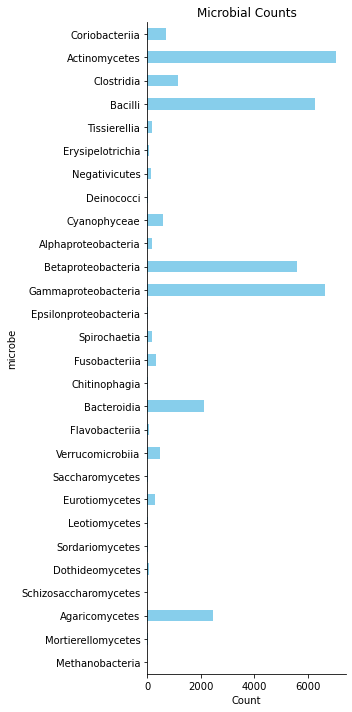

In [95]:
# plotting the barplot
microbes.plot(kind='barh', x='microbe', y='sum', legend=False, color='skyblue')

plt.xlabel('Count')
plt.title('Microbial Counts')
plt.gca().invert_yaxis()  # To display the highest value at the top

# Removing the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gcf().set_size_inches(5, 10)

# Final layout adjustments
plt.tight_layout()

plt.savefig('/.../barplot_Figure_2b.pdf')
